In [13]:
import numpy as np
import pandas as pd
import umap
import sklearn.decomposition
import sklearn.svm, sklearn.linear_model
import sklearn.metrics, sklearn.preprocessing

import os
import tqdm
import matplotlib.pyplot as plt

import src
import temp_embd2repre

chromosome_list = [str(i) for i in range(1, 23)] + ["X"]

def getFeature(chromosome: str, version: int, unit: str):
    # read the feature
    if version == 1:
        selector = temp_embd2repre.Selector("data/develop/v1/feature/{}".format(chromosome))
        feature = selector[:]
    if version == 2:
        selector = src.Selector("data/develop/v2/feature")
        feature = selector.getFeature(chromosome)

    # transform the feature if needed
    if version == 2 and unit == "position":
        position = feature[:, 0] * 1000 + feature[:, 1] * 100 + 50
        feature = np.column_stack((position, feature[:, 2]))
        feature = feature[np.lexsort((-feature[:, 1],))]
    if version == 1 and unit == "bucket":
        hash_idx = feature[:, 0] // 1000
        bucket_idx = (feature[:, 0] % 1000) // 100
        feature = np.column_stack((hash_idx, bucket_idx, feature[:, 1]))
        feature = feature[np.lexsort((feature[:, 1], feature[:, 0]))]

    # unit == "position":
    #   (position, distance), sort by distance
    # unit == "bucket":
    #   (hash_idx, bucket_idx, distance), sort by hash_idx and bucket_idx
    return feature

In [18]:
""" embd_stanford and mean """

profile = pd.read_csv("data/develop/v1/profile.csv")

embd_stanford = {sample: None for sample in profile["sample"]}
for chromosome in chromosome_list:
    selection = temp_embd2repre.Selector(
        os.path.join("data/develop/v1/feature", chromosome)
    )
    for i in len(profile):
        embd_temp = selection.apply(
            os.path.join(profile["embd_fold"].iloc[i], f"{chromosome}.npy")
        )
        if embd_stanford[profile["sample"].iloc[i]] is None: 
            embd_stanford[profile["sample"].iloc[i]] = embd_temp
        else:
            embd_stanford[profile["sample"].iloc[i]] = np.concatenate(
                (embd_stanford[profile["sample"].iloc[i]], embd_temp), axis=0
            )
# combine all embd, remove all the nan row
embd_all = np.concatenate([embd_stanford[s] for s in profile["sample"]], axis=0)
embd_all = embd_all[~np.isnan(embd_all).all(axis=1)]
# calculate the mean and fill the embd nan row with mean
# so that these nan will be 0 in pca
mean = np.mean(embd_all, axis=0)
for run in profile_stanford["Run"]:
    embd_stanford[run] = np.where(np.isnan(embd_stanford[run]), mean, embd_stanford[run])


/mnt/efs_v2/dbgap_tcga/users/tianrui.qi/SIP-DB2/data/develop/v1/embd/SRR8924591


TypeError: Selector.apply() missing 1 required positional argument: 'self'

## Compare feature of v1 and v2

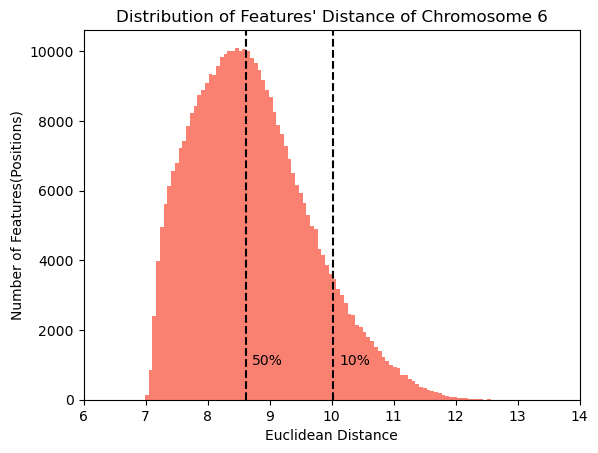

[30085884 30884132 31027312 31034704 31884816 32268724 30884124 32097234
 31420008 32829700]


In [9]:
feature = getFeature("6", 1, "position")
upper = int(np.ceil(feature[0, 1]))
lower = int(np.floor(feature[-1, 1]))
# 10%
upper_10 = feature[int(len(feature)*0.1), 1]
plt.axvline(upper_10, color="black", linestyle="--")
plt.text(upper_10+0.1, plt.ylim()[1]*1000, "10%")
# 50%
upper_50 = feature[int(len(feature)*0.5), 1]
plt.axvline(upper_50, color="black", linestyle="--")
plt.text(upper_50+0.1, plt.ylim()[1]*1000, "50%")
# hist
plt.hist(feature[:, 1], bins=100, color="salmon")
plt.xlim(lower, upper)
plt.title("Distribution of Features' Distance of Chromosome 6")
plt.xlabel("Euclidean Distance")
plt.ylabel("Number of Features(Positions)")
plt.show()
print(feature[:10, 0].astype(int))

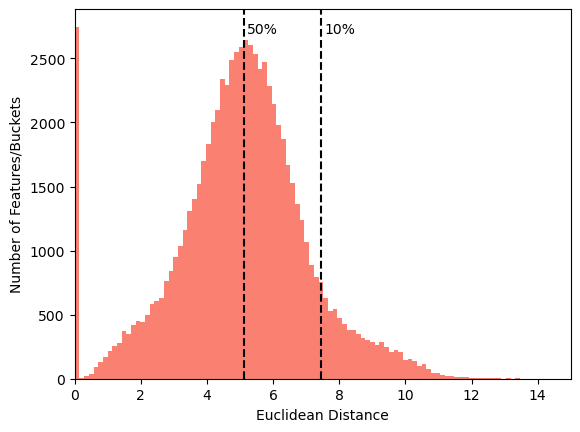

[28297750 31741350 29676150 26373250 31138750 27457150 32335850 33084850
 29672450 29676050]


In [12]:
feature = getFeature("6", 2, "position")
upper = int(np.ceil(feature[0, 1]))
lower = int(np.floor(feature[-1, 1]))
# 10%
upper_10 = feature[int(len(feature)*0.1), 1]
plt.axvline(upper_10, color="black", linestyle="--")
plt.text(upper_10+0.1, plt.ylim()[1]*2700, "10%")
# 50%
upper_50 = feature[int(len(feature)*0.5), 1]
plt.axvline(upper_50, color="black", linestyle="--")
plt.text(upper_50+0.1, plt.ylim()[1]*2700, "50%")
# hist
plt.hist(feature[:, 1], bins=100, color="salmon")
plt.xlim(lower, upper)
plt.xlabel("Euclidean Distance")
plt.ylabel("Number of Features/Buckets")
plt.show()
print(feature[:10, 0].astype(int))

## Prediction

In [ ]:
# get representation and label
profile = pd.read_csv("data/profile.csv")
profile = profile[profile["dataset"] == "stanford"]
repre = selector.getRepre(profile["embd_fold"].to_list(), verbal=False)
label = profile["Treatment"].apply(lambda x: 0 if x == "pre anti-PD-1" else 1).to_list()
# pca repre
pca = sklearn.decomposition.PCA(n_components=8)
repre_pca = pca.fit_transform(repre)
# plot pca 1 and 2, color by label
plt.scatter(repre_pca[:, 1], repre_pca[:, 2], c=label)
plt.show()

In [ ]:
repre = selector.getRepre()

In [ ]:
# read profile
profile = pd.read_csv("data/profile.csv")
profile = profile[profile["dataset"] == "tcgaskcm"]
profile = pd.concat([
    profile[profile["easy"] == 1], profile[profile["hard"] == 1]
]).reset_index(drop=True)
# random sample train, valid, test using pandas sample
profile_train = profile.sample(frac=0.6, random_state=0)
profile_valid = profile.drop(profile_train.index).sample(frac=0.5, random_state=0)
profile_test  = profile.drop(profile_train.index).drop(profile_valid.index)

#profile_train = profile[profile["train"] == 1]
#profile_valid = profile[profile["valid"] == 1]
#profile_test  = profile[profile["test"]  == 1]
# representation
repre_train = selector.getRepre(profile_train["embd_fold"].to_list(), recalculate=False)   # (497, 768)
repre_valid = selector.getRepre(profile_valid["embd_fold"].to_list(), recalculate=False)   # (216, 768)
repre_test  = selector.getRepre(profile_test["embd_fold"].to_list(), recalculate=False)    # (215, 768)
repre = np.vstack([repre_train, repre_valid, repre_test])               # (928, 768)
# PCA
pca = sklearn.decomposition.PCA(n_components=500)
pca = pca.fit(repre)
repre_train = pca.transform(repre_train)    # (497, 768)
repre_valid = pca.transform(repre_valid)    # (216, 768)
repre_test  = pca.transform(repre_test)     # (215, 768)

In [ ]:
plt.scatter(repre_train[:, 0], repre_train[:, 1], s=5)
plt.show()

In [ ]:
start, end = 0, 100
t1, t2 = 0.2, 0.4

In [ ]:
## T Cells CD8
# label
label_train = profile_train["Leukocyte Fraction"]
label_valid = profile_valid["Leukocyte Fraction"]
label_test  = profile_test ["Leukocyte Fraction"]
# prediction
#model = sklearn.linear_model.LinearRegression().fit(repre_train[:, start:end], label_train)
model = sklearn.svm.SVR().fit(repre_train[:, start:end], label_train)
pred_train = model.predict(repre_train[:, start:end])
pred_valid = model.predict(repre_valid[:, start:end])
pred_test  = model.predict(repre_test[:, start:end])
# performance
mae_train = sklearn.metrics.mean_absolute_error(label_train, pred_train)
mae_valid = sklearn.metrics.mean_absolute_error(label_valid, pred_valid)
print(f"train mae: {mae_train:.3f}")
print(f"valid mae: {mae_valid:.3f}")
# view T Cells CD8 < 0.1 as low, 0.1 <= T Cells CD8 < 0.3 as middle, 
# 0.3 <= T Cells CD8 as high, check pred_valid and profile_valid["T Cells CD8"]
# performance in classification way
label_class_train = np.digitize(label_train, [t1, t2])
label_class_valid = np.digitize(label_valid, [t1, t2])
pred_class_train = np.digitize(pred_train, [t1, t2])
pred_class_valid = np.digitize(pred_valid, [t1, t2])
# 3 * 3 confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(label_class_train, pred_class_train)
print(confusion_matrix)
confusion_matrix = sklearn.metrics.confusion_matrix(label_class_valid, pred_class_valid)
print(confusion_matrix)
# print accuracy
accuracy_train = sklearn.metrics.accuracy_score(label_class_train, pred_class_train)
accuracy_valid = sklearn.metrics.accuracy_score(label_class_valid, pred_class_valid)
print(f"train accuracy: {accuracy_train:.3f}")
print(f"valid accuracy: {accuracy_valid:.3f}")

# plot pred_valid as x and label_valid as y
plt.scatter(pred_train, label_train, color="blue", s=10)
plt.scatter(pred_valid, label_valid, color="red", s=10)
plt.plot([0, 0.5], [0, 0.5], color="black")
plt.xlabel("pred")
plt.ylabel("label")
plt.show()

In [ ]:
# TODO: prediction using Th2 Cells as lable and svm as model
svm = sklearn.svm.SVR().fit(repre_train, profile_train["Th2 Cells"])
pred_train = svm.predict(repre_train)
pred_valid = svm.predict(repre_valid)
mae_train = sklearn.metrics.mean_absolute_error(profile_train["Th2 Cells"], pred_train)
mae_valid = sklearn.metrics.mean_absolute_error(profile_valid["Th2 Cells"], pred_valid)
print(f"train mae: {mae_train:.2f}")
print(f"valid mae: {mae_valid:.2f}")

## Visulization

In [ ]:
# profile 0: nan to 0
# profile 1: remove nan row

# representation
profile = pd.read_csv("data/profile0.csv")
profile = profile.iloc[23:].reset_index(drop=True)
repre = np.hstack([
    np.load(profile.loc[i, "repre_path"]) for i in range(len(profile))
    if not pd.isna(profile.loc[i, "repre_path"])
]).T
# for each column, if there are np.nan in that column, drop that column
repre = repre[:, np.all(~np.isnan(repre), axis=0)]  # comment for 0, un for 1
repre = np.nan_to_num(repre, nan=0.0)
# fit
visu_pca = sklearn.decomposition.PCA(n_components=8).fit(repre)
visu_umap = umap.UMAP(n_components=3).fit(repre)
# transform
idx = [
    i for i in range(len(profile)) if not pd.isna(profile.loc[i, "repre_path"])
]
profile.loc[idx, [f"pca{p}" for p in range(8)]] = visu_pca.transform(repre)
profile.loc[idx, [f"umap{u}" for u in range(3)]] = visu_umap.transform(repre)
# save
profile.to_csv("data/profile2.csv", index=False)

## Profile

In [ ]:
# { chromosome : (hash_idx, bucket_idx, distance) }
feature = Selector("data/feature").getFeature()
# remove distance and ndarray dtype from float to int
# { chromosome : (hash_idx, bucket_idx) }
feature = {c: np.array([f[:2] for f in feature[c]], dtype=int) for c in feature}
result = []
for c in chromosome_list:
    for hash_idx, bucket_idx in feature[c]:
        result.append((c, hash_idx*1000 + bucket_idx*100, hash_idx*1000 + (bucket_idx+1)*100))
result = pd.DataFrame(result, columns=["chromosome", "start", "end"])
result.to_csv("data/temp/feature.csv", index=False)

In [ ]:
hash_idx_max = {
    "1": 249000,  "2": 243000,  "3": 199000,  "4": 191000,
    "5": 182000,  "6": 171000,  "7": 160000,  "8": 146000,
    "9": 139000, "10": 134000, "11": 136000, "12": 134000,
    "13": 115000, "14": 108000, "15": 102000, "16":  91000,
    "17":  84000, "18":  81000, "19":  59000, "20":  65000,
    "21":  47000, "22":  51000,  "X": 157000,
}

## bed
# read bed file
bed = pd.read_csv(
    "data/temp/rgc_gxs_v1_hg38.bed", 
    sep="\t", header=0, names=["chromosome", "start", "end"]
)
# remove chr prefix
bed["chromosome"] = bed["chromosome"].apply(lambda x: x[3:])
# keep chromosome 1-22 and X
bed = bed[bed['chromosome'].isin(chromosome_list)]
# transform bed from range list to one hot
bed_one_hot = {
    c: np.zeros((hash_idx_max[c] * 1000), dtype=bool) for c in chromosome_list
}
for _, row in bed.iterrows():
    chromosome, start, end = row[['chromosome', 'start', 'end']]
    bed_one_hot[chromosome][start:end] = True

## feature
# { chromosome : (hash_idx, bucket_idx, distance) }
feature = Selector("data/feature").getFeature()
# remove distance and ndarray dtype from float to int
# { chromosome : (hash_idx, bucket_idx) }
feature = {c: np.array([f[:2] for f in feature[c]], dtype=int) for c in feature}
# transform feature from bucket list to one hot
feature_one_hot = {
    c: np.zeros((hash_idx_max[c] * 1000), dtype=bool) for c in chromosome_list
}
for c in feature:
    for hash_idx, bucket_idx in feature[c]:
        feature_one_hot[c][
            hash_idx*1000 + bucket_idx*100 : hash_idx*1000 + (bucket_idx+1)*100
        ] = True

# calculate overlap
for c in bed_one_hot:
    overlap = np.logical_and(bed_one_hot[c], feature_one_hot[c])
    overlap_bed = (np.sum(overlap) / np.sum(bed_one_hot[c])) * 100 
    overlap_feature = (np.sum(overlap) / np.sum(feature_one_hot[c])) * 100
    print(
        f"Chromosome {c}:\t",
        f"overlap/bed: {np.sum(overlap):7,} / {np.sum(bed_one_hot[c]):9,} = {overlap_bed:5.2f}%\t",
        f"overlap/feature: {np.sum(overlap):7,} / {np.sum(feature_one_hot[c]):9,} = {overlap_feature:5.2f}%"
    )

In [ ]:
p_val = 1e-3

snps = pd.read_csv("data/snps.csv", usecols=["Chr", "Pos", "Pval"])
# filter by pval < 1e-3
snps = snps[snps["Pval"] < p_val][["Chr", "Pos"]]
# sort by Chr and then Pos
snps = snps.sort_values(["Chr", "Pos"])
# transform chromosome from int 1-23 to str 1-22, X
snps["Chr"] = snps["Chr"].apply(lambda x: str(x) if x < 23 else "X")
# split by chromosome, { chromosome : (pos) }
snps = snps.groupby("Chr")["Pos"].apply(list).to_dict()

for c, pos in snps.items():
    snps_in_bed, snps_in_feature = 0, 0
    for p in pos:
        if bed_one_hot[c][p]: snps_in_bed += 1
        if feature_one_hot[c][p]: snps_in_feature += 1
    print(
        f"Chromosome {c}:\t",
        f"snps_in_bed/bed: {snps_in_bed:6,} / {len(pos):6,} = {(snps_in_bed / len(pos)) * 100:5.2f}%\t",
        f"snps_in_feature/feature: {snps_in_feature:6,} / {len(pos):6,} = {(snps_in_feature / len(pos)) * 100:5.2f}%"
    )

In [ ]:
p_val = 1e-2

snps = pd.read_csv("data/snps.csv", usecols=["Chr", "Pos", "Pval"])
# filter by pval < 1e-2
snps = snps[snps["Pval"] < p_val][["Chr", "Pos"]]
# sort by Chr and then Pos
snps = snps.sort_values(["Chr", "Pos"])
# transform chromosome from int 1-23 to str 1-22, X
snps["Chr"] = snps["Chr"].apply(lambda x: str(x) if x < 23 else "X")
# split by chromosome, { chromosome : (pos) }
snps = snps.groupby("Chr")["Pos"].apply(list).to_dict()

for c, pos in snps.items():
    snps_in_bed, snps_in_feature = 0, 0
    for p in pos:
        if bed_one_hot[c][p]: snps_in_bed += 1
        if feature_one_hot[c][p]: snps_in_feature += 1
    print(
        f"Chromosome {c}:\t",
        f"snps_in_bed/bed: {snps_in_bed:7,} / {len(pos):7,} = {(snps_in_bed / len(pos)) * 100:5.2f}%\t",
        f"snps_in_feature/feature: {snps_in_feature:7,} / {len(pos):7,} = {(snps_in_feature / len(pos)) * 100:5.2f}%"
    )